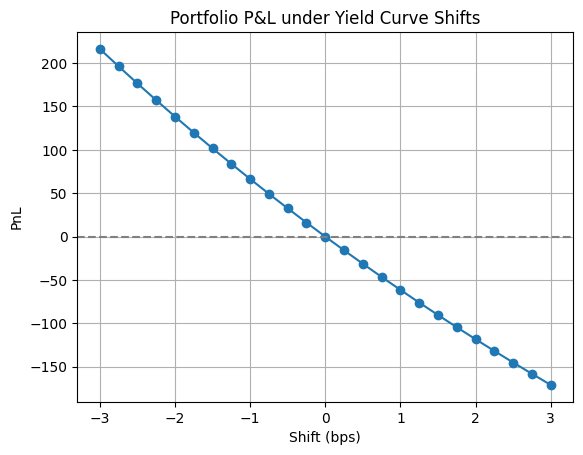

Macaulay Duration: 4.50 years
Modified Duration: 4.41
Convexity: 23.85


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Bond Pricing, Duration, Convexity
# -----------------------------
def bond_price(face_value, coupon_rate, maturity, ytm, freq=2):
    """
    Price a fixed-rate bond.
    """
    periods = int(maturity * freq)
    coupon = coupon_rate * face_value / freq
    discount_factors = [(1 + ytm/freq) ** -t for t in range(1, periods + 1)]
    pv_coupons = sum(coupon * df for df in discount_factors)
    pv_face = face_value * discount_factors[-1]
    return pv_coupons + pv_face

def duration_convexity(face_value, coupon_rate, maturity, ytm, freq=2):
    """
    Calculate Macaulay Duration, Modified Duration, and Convexity.
    """
    periods = int(maturity * freq)
    coupon = coupon_rate * face_value / freq
    cashflows = np.array([coupon] * periods)
    cashflows[-1] += face_value
    times = np.arange(1, periods + 1)
    discount_factors = (1 + ytm/freq) ** -times

    pv_cashflows = cashflows * discount_factors
    price = pv_cashflows.sum()

    macaulay_duration = np.sum(times * pv_cashflows) / (price * freq)
    modified_duration = macaulay_duration / (1 + ytm/freq)
    convexity = np.sum(pv_cashflows * times * (times + 1)) / (price * (freq**2))

    return macaulay_duration, modified_duration, convexity

# -----------------------------
# Portfolio Simulation
# -----------------------------
def portfolio_value(bonds, ytm_shift=0):
    """
    Calculate portfolio value under yield shift.
    bonds: list of dicts [{face, coupon, maturity, ytm, weight}]
    """
    total = 0
    for b in bonds:
        price = bond_price(
            face_value=b["face"],
            coupon_rate=b["coupon"],
            maturity=b["maturity"],
            ytm=b["ytm"] + ytm_shift
        )
        total += price * b["weight"]
    return total

def simulate_shifts(bonds, shifts):
    base_value = portfolio_value(bonds, 0)
    results = []
    for s in shifts:
        new_value = portfolio_value(bonds, s)
        pnl = new_value - base_value
        results.append((s*100, pnl))
    return pd.DataFrame(results, columns=["Shift (bps)", "PnL"])

# -----------------------------
# Example Usage
# -----------------------------
if __name__ == "__main__":
    # Sample portfolio
    bonds = [
        {"face": 1000, "coupon": 0.05, "maturity": 5, "ytm": 0.04, "weight": 0.5},
        {"face": 1000, "coupon": 0.06, "maturity": 10, "ytm": 0.05, "weight": 0.5}
    ]

    # Parallel shifts from -300 bps to +300 bps
    shifts = np.linspace(-0.03, 0.03, 25)
    df = simulate_shifts(bonds, shifts)

    # Plot
    plt.plot(df["Shift (bps)"], df["PnL"], marker="o")
    plt.axhline(0, color="gray", linestyle="--")
    plt.title("Portfolio P&L under Yield Curve Shifts")
    plt.xlabel("Shift (bps)")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.show()

    # Duration & Convexity for one bond
    D, Dmod, C = duration_convexity(1000, 0.05, 5, 0.04)
    print(f"Macaulay Duration: {D:.2f} years")
    print(f"Modified Duration: {Dmod:.2f}")
    print(f"Convexity: {C:.2f}")
